In [7]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor

In [9]:
#Load and Clean the Data
df = pd.read_csv('../results/outputs/scaled_data.csv')
print(f"Dataset loaded! Shape: {df.shape}")

#Remove unwanted columns
unwanted_cols = [col for col in df.columns if 'unnamed' in col.lower() or 'index' in col.lower()]
if unwanted_cols:
    df = df.drop(columns=unwanted_cols)
    print(f"Removed unwanted columns: {unwanted_cols}")

print(f"Clean dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset loaded! Shape: (3063, 21)
Removed unwanted columns: ['Unnamed: 0']
Clean dataset shape: (3063, 20)
Columns: ['name', 'year', 'selling_price', 'km_driven', 'transmission', 'owner', 'fuel_Diesel', 'fuel_Electric', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Individual', 'seller_type_Trustmark Dealer', 'car_age', 'brand_name', 'avg_km_per_year', 'brand_popularity', 'price_per_km', 'age_group', 'usage_group', 'popularity_group']


In [10]:
#Prepare Data for Analysis
#Separate features and target
target = 'selling_price'
if target in df.columns:
    X = df.drop(target, axis=1)  # Features
    y = df[target]               # Target (price)
    print(f"Features: {X.shape[1]} columns")
    print(f"Target: {target}")
else:
    print("Warning: selling_price not found!")
    X = df
    y = None

Features: 19 columns
Target: selling_price


In [25]:
#Find Most Important Features
if y is not None:
    print(f"Analyzing {X.shape[1]} features...")
    
    # CHECK DATA TYPES FIRST
    print(f"Data types in features:")
    print(X.dtypes.value_counts())
    
    # FILTER OUT NON-NUMERIC COLUMNS
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
    
    print(f"Numeric columns: {len(numeric_columns)}")
    print(f"Non-numeric columns: {len(non_numeric_columns)}")
    
    if len(non_numeric_columns) > 0:
        print(f"Non-numeric columns found: {list(non_numeric_columns)}")
        print("Using only numeric columns for correlation analysis...")
    
    # USE ONLY NUMERIC FEATURES FOR CORRELATION
    X_numeric = X[numeric_columns]
    
    if len(X_numeric.columns) == 0:
        print("ERROR: No numeric columns found!")
    else:
        #Check correlation with price (only numeric features)
        correlations = X_numeric.corrwith(y).abs().sort_values(ascending=False)
        
        print("Top 10 features by correlation:")
        print(correlations.head(10))
        
        
        # For Random Forest, we need to handle non-numeric data
        X_for_rf = X.copy()
        
        # Convert non-numeric columns to numeric (simple label encoding)
        for col in non_numeric_columns:
            if X_for_rf[col].dtype == 'object':
                X_for_rf[col] = pd.Categorical(X_for_rf[col]).codes
        
        rf = RandomForestRegressor(n_estimators=50, random_state=42)
        rf.fit(X_for_rf, y)
        
        # Get feature importance scores
        importance_scores = pd.Series(rf.feature_importances_, index=X_for_rf.columns)
        importance_scores = importance_scores.sort_values(ascending=False)
        
        print("Top 10 features by Random Forest:")
        print(importance_scores.head(10))
        
        
else:
    print("Cannot find important features without target variable")
    correlations = None
    importance_scores = None

Analyzing 19 features...
Data types in features:
float64    6
bool       6
object     5
int64      2
Name: count, dtype: int64
Numeric columns: 8
Non-numeric columns: 11
Non-numeric columns found: ['name', 'fuel_Diesel', 'fuel_Electric', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Individual', 'seller_type_Trustmark Dealer', 'brand_name', 'age_group', 'usage_group', 'popularity_group']
Using only numeric columns for correlation analysis...
Top 10 features by correlation:
year                0.654623
car_age             0.654623
owner               0.294845
km_driven           0.270688
brand_popularity    0.153246
avg_km_per_year     0.098031
price_per_km        0.002261
transmission             NaN
dtype: float64
Top 10 features by Random Forest:
price_per_km              0.698512
km_driven                 0.119326
fuel_Diesel               0.079240
avg_km_per_year           0.068124
name                      0.015453
car_age                   0.004407
year                      0.003882
br

In [ ]:
#Select Best Features
# Choose top 10 features based on correlation
n_features = 10

if y is not None and 'correlations' in locals() and 'importance_scores' in locals():
    print(f"Selecting {n_features} best features using multiple methods...")
    
    #Top correlation features
    top_corr_features = correlations.head(15).index.tolist()
    print(f"Top correlation features: {top_corr_features[:5]}...")
    
    # Score based on correlation rank
    for i, feature in enumerate(top_corr_features):
        feature_scores[feature] = feature_scores.get(feature, 0) + (15 - i)
    
    # Sort by combined score
    best_features_combined = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
    best_features = [feature for feature, score in best_features_combined[:n_features]]
    
    print(f"\nSelected {n_features} best features (combined method):")
    for i, feature in enumerate(best_features, 1):
        corr_val = correlations.get(feature, 0)
        rf_val = importance_scores.get(feature, 0)
        combined_score = feature_scores[feature]
        print(f"{i}. {feature}")
        print(f"   Correlation: {corr_val:.3f} | RF Importance: {rf_val:.3f} | Combined Score: {combined_score}")
    
    final_features = best_features
    
    print(f"\nFinal selected features: {final_features}")

else:
    print("Error: Feature importance analysis not completed properly")
    final_features = X.columns.tolist()[:n_features]

# Create dataset with selected features
df_selected = X[final_features].copy()
if y is not None:
    df_selected[target] = y

print(f"\nSelected features dataset shape: {df_selected.shape}")

# Show feature statistics
print(f"\nFeature Selection Summary:")
for i, feature in enumerate(final_features, 1):
    print(f"{i}. {feature}")

Selecting 10 best features using multiple methods...
Top correlation features: ['year', 'car_age', 'owner', 'km_driven', 'brand_popularity']...

Selected 10 best features (combined method):
1. km_driven
   Correlation: 0.271 | RF Importance: 0.119 | Combined Score: 26
2. year
   Correlation: 0.655 | RF Importance: 0.004 | Combined Score: 24
3. car_age
   Correlation: 0.655 | RF Importance: 0.004 | Combined Score: 24
4. price_per_km
   Correlation: 0.002 | RF Importance: 0.699 | Combined Score: 24
5. avg_km_per_year
   Correlation: 0.098 | RF Importance: 0.068 | Combined Score: 22
6. brand_popularity
   Correlation: 0.153 | RF Importance: 0.004 | Combined Score: 19
7. owner
   Correlation: 0.295 | RF Importance: 0.001 | Combined Score: 17
8. fuel_Diesel
   Correlation: 0.000 | RF Importance: 0.079 | Combined Score: 13
9. name
   Correlation: 0.000 | RF Importance: 0.015 | Combined Score: 11
10. transmission
   Correlation: nan | RF Importance: 0.000 | Combined Score: 8

Final selected f

In [28]:
#Apply PCA to reduce dimensions (optional)
#Use only numeric columns for PCA
numeric_columns = X.select_dtypes(include=[np.number]).columns
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns

print(f"Total features: {X.shape[1]}")
print(f"Numeric features: {len(numeric_columns)}")
print(f"Non-numeric features: {len(non_numeric_columns)}")

if len(non_numeric_columns) > 0:
    print(f"Excluding non-numeric columns: {list(non_numeric_columns)}")

# Use only numeric features for PCA
X_numeric_for_pca = X[numeric_columns]

if len(X_numeric_for_pca.columns) == 0:
    print("ERROR: No numeric columns available for PCA!")
else:
    print(f"Using {len(X_numeric_for_pca.columns)} numeric features for PCA")
    
    # Apply PCA to numeric features only
    pca = PCA()
    X_pca_full = pca.fit_transform(X_numeric_for_pca)
    
    # Check how much variance each component explains
    variance_explained = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_explained)
    
    # Find number of components for 95% variance
    target_variance = 0.95
    n_components = np.where(cumulative_variance >= target_variance)[0][0] + 1
    
    print(f"\nPCA Results:")
    print(f"Need {n_components} components to keep {target_variance*100}% of information")
    print(f"Original numeric features: {X_numeric_for_pca.shape[1]}")
    print(f"PCA components: {n_components}")
    print(f"Reduction: {X_numeric_for_pca.shape[1] - n_components} features removed")
    
    # Apply PCA with optimal number of components
    pca_final = PCA(n_components=n_components)
    X_pca = pca_final.fit_transform(X_numeric_for_pca)
    
    # Create PCA dataset
    pca_columns = [f'Component_{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(X_pca, columns=pca_columns)
    if y is not None:
        df_pca[target] = y.values
    
    print(f"PCA dataset shape: {df_pca.shape}")

Total features: 19
Numeric features: 8
Non-numeric features: 11
Excluding non-numeric columns: ['name', 'fuel_Diesel', 'fuel_Electric', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Individual', 'seller_type_Trustmark Dealer', 'brand_name', 'age_group', 'usage_group', 'popularity_group']
Using 8 numeric features for PCA

PCA Results:
Need 3 components to keep 95.0% of information
Original numeric features: 8
PCA components: 3
Reduction: 5 features removed
PCA dataset shape: (3063, 4)


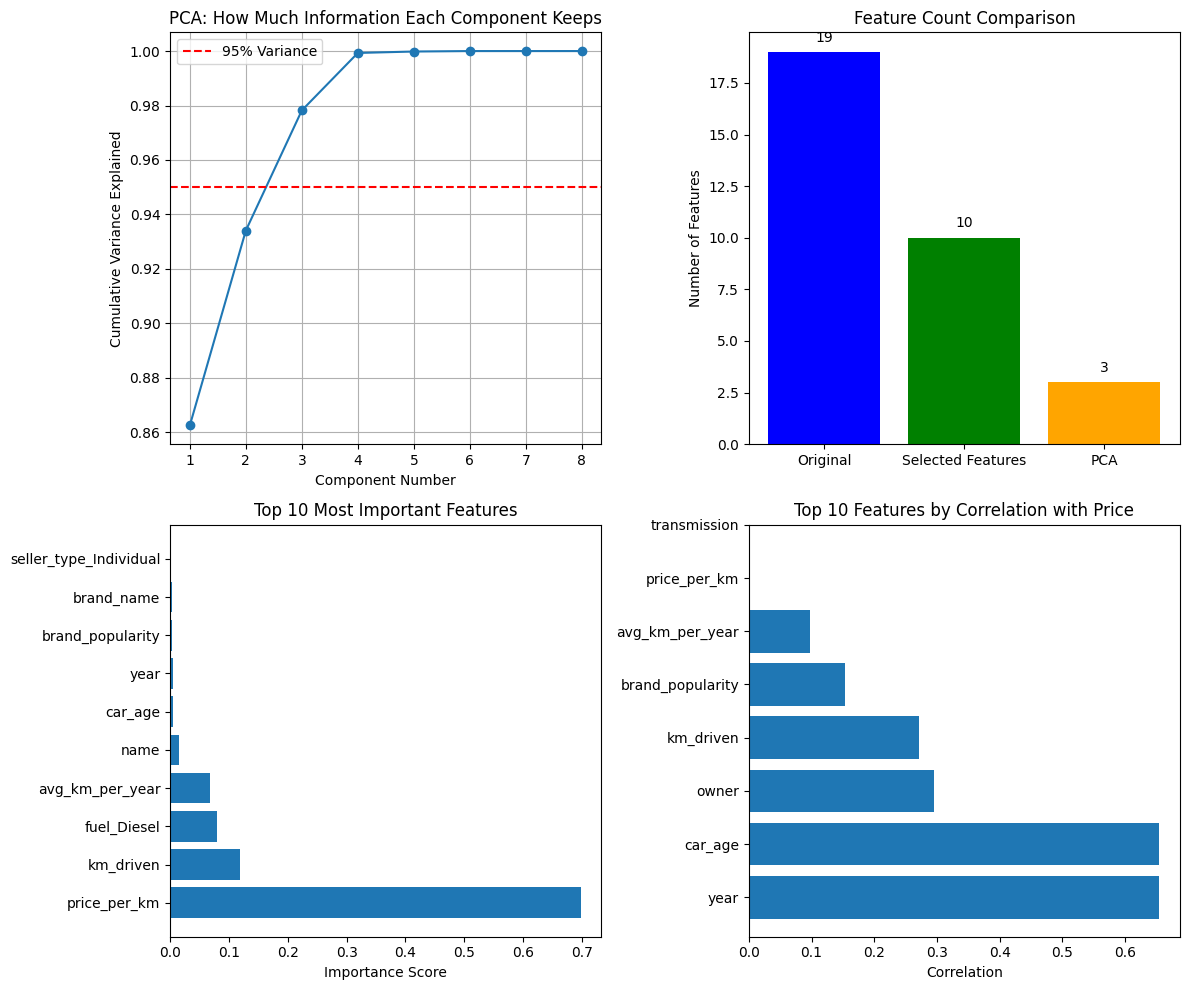

In [30]:
#Create Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: PCA Variance Explained
axes[0,0].plot(range(1, len(cumulative_variance[:20]) + 1), cumulative_variance[:20], 'o-')
axes[0,0].axhline(y=0.95, color='red', linestyle='--', label='95% Variance')
axes[0,0].set_title('PCA: How Much Information Each Component Keeps')
axes[0,0].set_xlabel('Component Number')
axes[0,0].set_ylabel('Cumulative Variance Explained')
axes[0,0].legend()
axes[0,0].grid(True)

# Plot 2: Number of Features Comparison
methods = ['Original', 'Selected Features', 'PCA']
feature_counts = [X.shape[1], len(best_features), n_components]
bars = axes[0,1].bar(methods, feature_counts, color=['blue', 'green', 'orange'])
axes[0,1].set_title('Feature Count Comparison')
axes[0,1].set_ylabel('Number of Features')

# Add numbers on bars
for bar, count in zip(bars, feature_counts):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                   str(count), ha='center')

# Plot 3: Feature Importance (Top 10)
top_10_features = importance_scores.head(10)
axes[1,0].barh(range(len(top_10_features)), top_10_features.values)
axes[1,0].set_yticks(range(len(top_10_features)))
axes[1,0].set_yticklabels(top_10_features.index)
axes[1,0].set_title('Top 10 Most Important Features')
axes[1,0].set_xlabel('Importance Score')

# Plot 4: Correlation with Price (Top 10)
if y is not None:
    top_10_corr = correlations.head(10)
    axes[1,1].barh(range(len(top_10_corr)), top_10_corr.values)
    axes[1,1].set_yticks(range(len(top_10_corr)))
    axes[1,1].set_yticklabels(top_10_corr.index)
    axes[1,1].set_title('Top 10 Features by Correlation with Price')
    axes[1,1].set_xlabel('Correlation')

plt.tight_layout()
plt.savefig('../results/eda_visualizations/simple_dimensionality_reduction.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Save the reduced datasets
df_selected.to_csv('../results/outputs/data_best_features.csv', index=False)
print(f"Saved best features dataset: {df_selected.shape}")

# Print simple summary
print(f"""
SUMMARY:
- Started with: {X.shape[1]} features
- Best features selected: {len(best_features)} features  
- PCA components: {n_components} components
- Files saved:
  * data_best_features.csv ({df_selected.shape[1]} columns)
  * data_pca_components.csv ({df_pca.shape[1]} columns)
  * simple_dimensionality_reduction.png (visualizations)
""")

Saved best features dataset: (3063, 11)

SUMMARY:
- Started with: 19 features
- Best features selected: 10 features  
- PCA components: 3 components
- Files saved:
  * data_best_features.csv (11 columns)
  * data_pca_components.csv (4 columns)
  * simple_dimensionality_reduction.png (visualizations)

